In [3]:
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
import time

from torch.utils.data import DataLoader

from torchvision import transforms, datasets

### 模型构建

In [5]:
def nin_block(in_channels, out_channels, kernel_size, stride, padding):

    blk = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                       nn.ReLU(),
                       nn.Conv2d(out_channels, out_channels, kernel_size=1),
                       nn.ReLU(),
                       nn.Conv2d(out_channels, out_channels, kernel_size=1),
                       nn.ReLU())

    return blk

In [6]:
class GlobalAvgPool2d(nn.Module): #取代全连接层
    # 全局平均池化层可通过将池化窗口设置成输入的高和宽实现
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size = x.size()[2:]) # X: [batch_size, channels, height, width]

In [10]:
net = nn.Sequential(nin_block(3, 96, kernel_size=11, stride=4, padding=0),
                   nn.MaxPool2d(kernel_size=2, stride=2), #长宽各缩小一半
                   nin_block(96, 256, kernel_size=5,stride=1,padding=2),
                   nn.MaxPool2d(kernel_size=2, stride=2),
                   nin_block(256, 384, kernel_size=3,stride=1,padding=1),
                   nn.MaxPool2d(kernel_size=2, stride=2),
                   nin_block(384, 10, kernel_size=3,stride=1,padding=1), #根据标签数量设置最后一个nin_block
                   GlobalAvgPool2d(),
                   nn.Flatten())

In [12]:
x = torch.rand(1,3,224,224)
net(x).shape

torch.Size([1, 10])

In [14]:
for name, blk in net.named_children():
    x = blk(x)
    print(name, 'output size', x.shape)

0 output size torch.Size([1, 96, 54, 54])
1 output size torch.Size([1, 96, 27, 27])
2 output size torch.Size([1, 256, 27, 27])
3 output size torch.Size([1, 256, 13, 13])
4 output size torch.Size([1, 384, 13, 13])
5 output size torch.Size([1, 384, 6, 6])
6 output size torch.Size([1, 10, 6, 6])
7 output size torch.Size([1, 10, 1, 1])
8 output size torch.Size([1, 10])


## 数据集下载与预处理

In [28]:
data_transform = transforms.Compose([transforms.Resize(256), #把图片resize为256*256
                                   transforms.CenterCrop(224), #随机裁剪为224*224
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train_sets = datasets.CIFAR10(root = 'cifar_10', #选择数据的根目录
                             train = True, #选择训练集
                             download = True, transform=data_transform) #从网络上下载图片

test_sets = datasets.CIFAR10(root = 'cifar_10',
                             train = True, #选择测试集
                             download = True, transform=data_transform)


train_dataloader = DataLoader(train_sets, batch_size=256, shuffle=True)

test_dataloader = DataLoader(test_sets, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### 评估准确率函数构建

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [19]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    
    net.eval()
    for X,y in data_iter:
        X = X.to(device)
        y = y.to(device)
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() #argmax(dim=1)：对每个样本取预测概率最大的类别索引；== y：比较预测类别与真实标签，返回布尔张量；float()：将布尔值转为浮点数；sum()：统计当前批次中正确预测的总数；item()：将张量值转为 Python 标量（便于累加）
        n += y.shape[0] #batch_size

    return acc_sum/n

### 训练函数与测试函数构建

In [22]:
def train_model(model,train_dataloader,loss_func,optimizer):
    """ 模型训练函数 """
    model.train()
    total_loss = 0.
    for x,y in train_dataloader:
        y_hat = model(x.to(device))
        loss = loss_func(y_hat,y.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_dataloader)

def test_model(model,test_dataloader,loss_func):
    """ 模型测试函数 """
    model.eval()
    total_loss = 0.
    for x,y in test_dataloader:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(x)
            loss = loss_func(y_hat,y)
            total_loss += loss.item()

    return total_loss / len(test_dataloader), evaluate_accuracy(test_dataloader, model)

In [24]:
model = net.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 模型训练

In [32]:
n_epoch = 10

train_loss_list = []
test_loss_list = []
test_acc_list=[]
for i in range(n_epoch):
    train_loss = train_model(model, train_dataloader, loss_func, optimizer)
    test_loss, acc = test_model(model, test_dataloader, loss_func)
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(acc)
    print(f'train_loss: {train_loss}, test_loss: {test_loss}, test_acc: {acc}')

train_loss: 1.4687679069382804, test_loss: 1.4208564622627804, test_acc: 0.502
train_loss: 1.426937889687869, test_loss: 1.3770468358493522, test_acc: 0.51094
train_loss: 1.3803101917918847, test_loss: 1.3780729056471754, test_acc: 0.5172
train_loss: 1.343915581703186, test_loss: 1.3832868443578101, test_acc: 0.51554
train_loss: 1.303431399622742, test_loss: 1.2810106491646194, test_acc: 0.56184
train_loss: 1.269812389904139, test_loss: 1.2189082103159727, test_acc: 0.59214
train_loss: 1.2350188405538092, test_loss: 1.19582511389347, test_acc: 0.60246
train_loss: 1.2024818756142441, test_loss: 1.1793766399783552, test_acc: 0.60424
train_loss: 1.1728846351711117, test_loss: 1.117942620954855, test_acc: 0.63462
train_loss: 1.135592019679595, test_loss: 1.1126128971729132, test_acc: 0.634


### 可视化

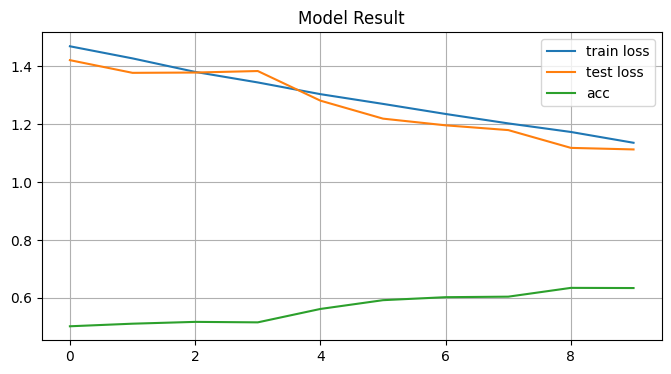

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label="train loss")
plt.plot(test_loss_list, label="test loss")
plt.plot(test_acc_list, label='acc')
plt.title("Model Result")
plt.grid()
plt.legend()
plt.show()